# Проект по работе с моделями машинного обучения

# Описание

Представлен набор данных показаний с датчиков с оценкой риска отказа оборудования.

Набор данных состоит из следующих объектов:

Температура (°C): Непрерывные данные, представляющие температуру в критических точках машины. Более высокие температуры могут указывать на потенциальные проблемы из-за перегрева.

Вибрация (Гц): Частота вибраций машины. Аномальные вибрации могут быть признаком механического несоосности, дисбаланса или износа.

Потребление мощности (кВт): Уровни потребления мощности машины. Скачки потребления мощности могут указывать на повышенную нагрузку или потенциальные механические проблемы.

Влажность (%): влажность окружающей среды вокруг машины. Высокий уровень влажности может повлиять на производительность машины и со временем привести к ее поломке.

Тип машины: Категориальные данные, указывающие тип машины (например, «Сверлильный станок», «Токарный станок», «Фрезерный станок»). Различные типы машин могут иметь уникальные модели отказов.

Целевая переменная:

Риск отказа: двоичная метка, где 0 указывает на нормальную работу, а 1 указывает на то, что машина подвержена риску отказа.

Необходимо найти наиболее результативную модель прогнозирования риска отказа оборудования.

# План проекта :
## 1.Обзор данных
### 1.1Загрузка библиотек
### 1.2 Загрузка данных
### 1.3 Просмотр данных
## 2. Предобработка данных
### 2.1 

## 1.Обзор данных

### 1.1 Загрузка библиотек

In [ ]:
pip install catboost

In [3]:
pip install lightgbm 

Note: you may need to restart the kernel to use updated packages.


In [5]:
!pip uninstall -y scikit-learn
!pip install scikit-learn==1.5.2

Found existing installation: scikit-learn 1.6.1
Uninstalling scikit-learn-1.6.1:
  Successfully uninstalled scikit-learn-1.6.1
     |████████████████████████████████| 12.1 MB 1.2 MB/s eta 0:00:01


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier 
from sklearn.preprocessing import OrdinalEncoder 
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import recall_score
from sklearn.utils import shuffle
from catboost import Pool, CatBoostClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier
from catboost import cv

### 1. 2 Загрузка данных

In [7]:
dt= pd.read_csv('/Users/ekaterinakasina/Documents/GitHub/data_science/machine_failure_dataset.csv')

### 1.3 Просмотр данных

Проверим первые несколько строк

In [8]:
dt.head(5)

,Temperature,Vibration,Power_Usage,Humidity,Machine_Type,Failure_Risk
0,74.967142,56.996777,8.649643,20.460962,Mill,1
1,68.617357,54.623168,9.710963,25.698075,Lathe,0
2,76.476885,50.298152,8.415160,27.931972,Drill,1
3,85.230299,46.765316,9.384077,39.438438,Lathe,1
4,67.658466,53.491117,6.212771,32.782766,Drill,1


На первый взгляд все впорядке. Но в такой точности в данных нет необходимости. Стоит подумать до округления данных до одной десятой, а то и до целых чисел.

Посмотрим на информацию по пропускам и типам объектов данных

In [9]:
dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Temperature   1000 non-null   float64
 1   Vibration     1000 non-null   float64
 2   Power_Usage   1000 non-null   float64
 3   Humidity      1000 non-null   float64
 4   Machine_Type  1000 non-null   object 
 5   Failure_Risk  1000 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 47.0+ KB


Пропусков нет, но нужно проверить на наличие NaN и посмотреть на наличие дубликатов

In [10]:
dt.describe()

,Temperature,Vibration,Power_Usage,Humidity,Failure_Risk
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,70.193321,50.354181,10.011668,29.906404,0.300000
std,9.792159,4.987272,1.966909,5.135663,0.458487
min,37.587327,35.298057,3.960976,15.352757,0.000000
25%,63.524097,46.968792,8.704001,26.312898,0.000000
50%,70.253006,50.315386,9.999498,30.000923,0.000000
75%,76.479439,53.644411,11.321831,33.334727,1.000000
max,108.527315,65.965538,17.852475,46.215465,1.000000


Видно, что распределение по целевому признаку не в равновесии смещено к работе без риска отказа(что логично). Отправная точка для показателя модели не 0.5. Медиана практически совпадает со средним, значит выбросы не смещают распределение. 
Для более наглядного отображения распределения данных и поиска выбосов используем boxplot

In [11]:
dt.dtypes

Temperature     float64
Vibration       float64
Power_Usage     float64
Humidity        float64
Machine_Type     object
Failure_Risk      int64
dtype: object

In [12]:
series = dt.columns.tolist()

In [13]:
series=series[0:4]
series

['Temperature', 'Vibration', 'Power_Usage', 'Humidity']

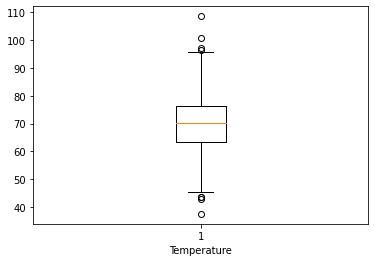

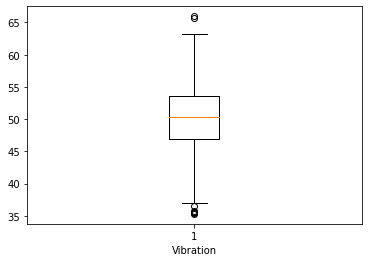

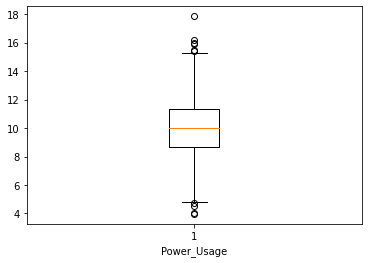

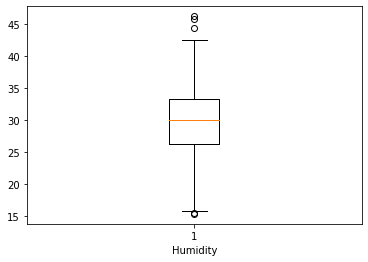

In [14]:
for i in series:
    plt.boxplot(dt[i])
    plt.xlabel(i)#Подпись для оси х
    plt.show()



Видно, что выбросов не так много, посмотрим на корреляцию признаков, перед тем как делать выводы

In [15]:
dt.corr()

,Temperature,Vibration,Power_Usage,Humidity,Failure_Risk
Temperature,1.000000,-0.040400,0.022129,-0.013321,0.029938
Vibration,-0.040400,1.000000,-0.011199,-0.054698,-0.001727
Power_Usage,0.022129,-0.011199,1.000000,0.021586,0.020971
Humidity,-0.013321,-0.054698,0.021586,1.000000,-0.018007
Failure_Risk,0.029938,-0.001727,0.020971,-0.018007,1.000000


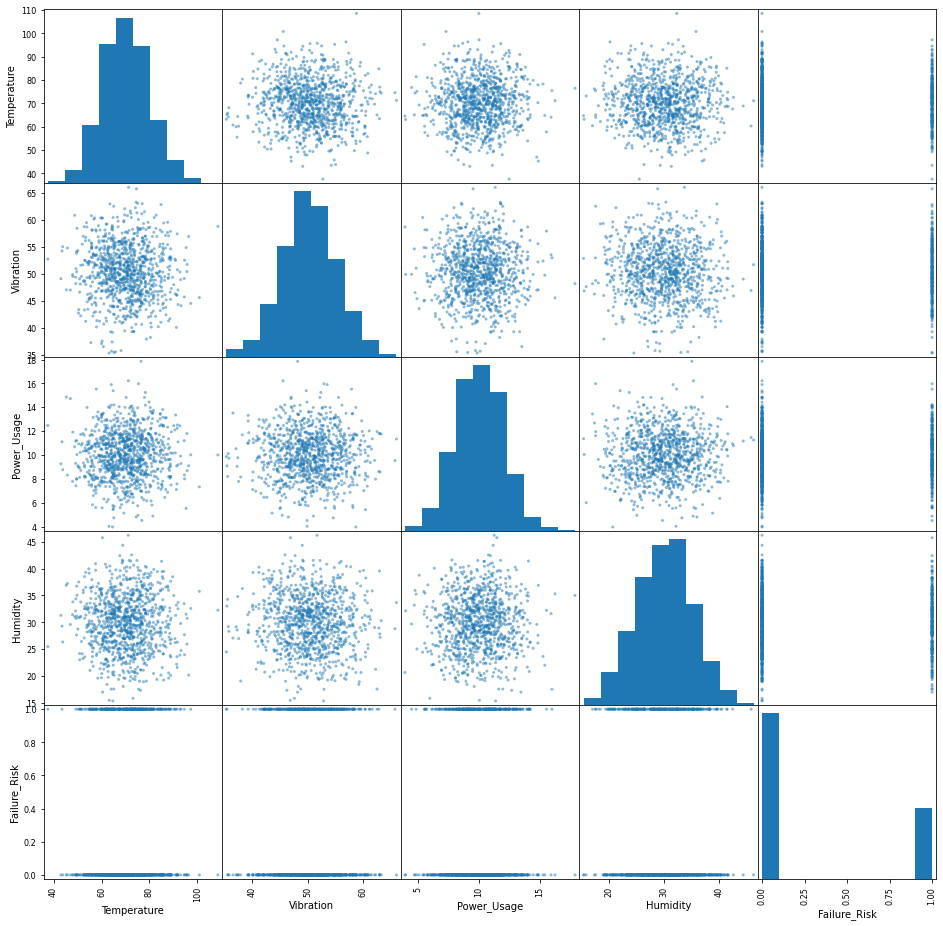

In [16]:
pd.plotting.scatter_matrix(dt,alpha=0.5,figsize=(16,16))
plt.show()

Проверим целевой признак на сбалансированность

0    0.7
1    0.3
Name: Failure_Risk, dtype: float64


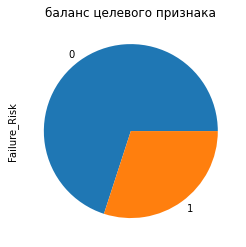

In [17]:
print(dt['Failure_Risk'].value_counts(normalize=True))
dt['Failure_Risk'].value_counts(normalize=True).plot(kind="pie", title = "баланс целевого признака");

#### Вывод 

По коэфициентам корреляции видно, что зависимостей нет. Гистограммы показывают на нормальное распределение, отбрасывать выбросы смысла нет. Дисбаланс целевого признака

In [18]:
dt.head()

,Temperature,Vibration,Power_Usage,Humidity,Machine_Type,Failure_Risk
0,74.967142,56.996777,8.649643,20.460962,Mill,1
1,68.617357,54.623168,9.710963,25.698075,Lathe,0
2,76.476885,50.298152,8.415160,27.931972,Drill,1
3,85.230299,46.765316,9.384077,39.438438,Lathe,1
4,67.658466,53.491117,6.212771,32.782766,Drill,1


In [19]:
dt.pivot_table(index='Machine_Type',
               values='Failure_Risk',
              aggfunc=['sum','mean'])

,sum,mean
,Failure_Risk,Failure_Risk
Machine_Type,,
Drill,104,0.311377
Lathe,105,0.310651
Mill,91,0.277439


## 2. Предобработка данных

In [20]:
df=dt.copy()

### 2.1 Приведение к "змеиному" стилю

In [21]:
df = df.rename(
columns={
'Temperature': 'temperature',
'Vibration': 'vibration',
'Power_Usage': 'power_usage',
'Humidity':'humidity',
'Failure_Risk':'failure_risk',
'Machine_Type': 'machine_type'}
)

### 2.1 Проверка на дубликаты

In [22]:
df.duplicated().sum()

0

### 2.2 Проверка на пропуски

Проверим на уникальные значения в столбце с категорией машин

In [23]:
df['machine_type'].unique()

array(['Mill', 'Lathe', 'Drill'], dtype=object)

 Отсутствует None, или другие заглушки

### 2.3 Преобразование данных

Округлим данные в столбцах до 0,1

In [24]:
series=[word.lower() for word in series]

In [25]:
df[series]=df[series].round(1)

#### Категоризируем числовые данные

Категоризируем данные по температуре, вибрации, влажности, мощности на основании данных полученных с boxplot. Сразу зададим числовые категории чтобы не кодировать их в дальнейшем

In [26]:
# не разобрался пока с функцией поквантилям, чтобы облегчить код
#q = df['Temperature'].quantile(0.75)
#df['Temperature']<=df['Temperature'].quantile(0.75)
#pd.to_numeric(df["score"], errors="coerce").quantile(q=0.33)
##def Power_Usage_group(power_usage):
    #if power_usage <= pd.to_numeric(power_usage, errors="coerce").quantile(q=0.25):
        #return '1'
    #if power_usage <= pd.to_numeric(power_usage, errors="coerce").quantile(q=0.75):
        #return '2'
    #if power_usage <= pd.to_numeric(power_usage, errors="coerce").quantile(q=0.995:
        #return '3'
    #return '4'
##                                                                           
#df['Power_Usage_group'] = df['Power_Usage'].apply(Power_Usage_group)

разобьем данные по температуре: менее 63 градусов - низкая, от 63 до 76 средняя(2), от 76 до 95 повышенная(3),выше 95 градусов - высокая(4). 

In [27]:
def temperature_group(temperature):
    if temperature <= 63:
        return '1'
    if temperature <= 76:
        return '2'
    if temperature <= 95:
        return '3'
    return '4'
df['temperature_group'] = df['temperature'].apply(temperature_group)

разобьем данные по вибрации: меннее 46 дБ - низкая(1), от 46 до 53 дБ - средняя(2), от 53 до 63 дБ - повышенная(3), выше 63 дБ - высокая(4)

In [28]:
def vibration_group(vibration):
    if vibration <= 46:
        return '1'
    if vibration <= 53:
        return '2'
    if vibration <= 63:
        return '3'
    return '4'
df['vibration_group'] = df['vibration'].apply(vibration_group)

разобьем данные по мощности: меннее 8.7 дБ - низкая(1), от 8.7 до 11.3 дБ - средняя(2), от 11.3 до 15.3 дБ - повышенная(3), выше 15.3 дБ - высокая(4)

In [29]:
def power_usage_group(power_usage):
    if power_usage <= 8.7:
        return '1'
    if power_usage <= 11.3:
        return '2'
    if power_usage <= 15.3:
        return '3'
    return '4'
df['power_usage_group'] = df['power_usage'].apply(power_usage_group)

разобьем данные по влажности: меннее 26 дБ - низкая(1), от 26 до 33 дБ - средняя(2), от 33 до 42 дБ - повышенная(3), выше 42 дБ - высокая(4)

In [30]:
def humidity_group(humidity):
    if humidity <= 26:
        return '1'
    if humidity <= 33:
        return '2'
    if humidity <= 42:
        return '3'
    return '4'
df['humidity_group'] = df['humidity'].apply(humidity_group)

In [31]:
df.head(10)

,temperature,vibration,power_usage,humidity,machine_type,failure_risk,temperature_group,vibration_group,power_usage_group,humidity_group
0,75.0,57.0,8.6,20.5,Mill,1,2,3,1,1
1,68.6,54.6,9.7,25.7,Lathe,0,2,3,2,1
2,76.5,50.3,8.4,27.9,Drill,1,3,2,1,2
3,85.2,46.8,9.4,39.4,Lathe,1,3,2,2,3
4,67.7,53.5,6.2,32.8,Drill,1,2,3,1,2
5,67.7,52.0,10.4,23.3,Drill,0,2,2,2,1
6,85.8,54.5,10.0,32.4,Lathe,0,3,3,2,2
7,77.7,53.2,8.4,22.3,Mill,1,3,3,1,1
8,65.3,55.2,11.3,35.4,Drill,0,2,3,2,3
9,75.4,47.3,11.9,27.6,Mill,1,2,2,3,2


Преобразуем названия столбцов в числовое значение, воспользуемся OrdinalEncoder

In [32]:
encoder = OrdinalEncoder() 
encoder.fit(df[['machine_type']]) 
df_ord = pd.DataFrame(encoder.fit_transform(df), 
                                                      columns=df.columns)

In [33]:
df_ord.head()

,temperature,vibration,power_usage,humidity,machine_type,failure_risk,temperature_group,vibration_group,power_usage_group,humidity_group
0,228.0,180.0,37.0,22.0,2.0,1.0,1.0,2.0,0.0,0.0
1,167.0,156.0,48.0,72.0,1.0,0.0,1.0,2.0,1.0,0.0
2,243.0,113.0,35.0,94.0,0.0,1.0,2.0,1.0,0.0,1.0
3,315.0,78.0,45.0,207.0,1.0,1.0,2.0,1.0,1.0,2.0
4,158.0,145.0,13.0,143.0,0.0,1.0,1.0,2.0,0.0,1.0


Почему-то OrdinalEncoder изменила данные по остальным признакам. Попробуем выделить столбец данных из основного датафрейма, закодировать его и добавить к основному датафрейму

In [34]:
obj_df = df.select_dtypes(include=['object']).copy()
obj_df.head(10)

,machine_type,temperature_group,vibration_group,power_usage_group,humidity_group
0,Mill,2,3,1,1
1,Lathe,2,3,2,1
2,Drill,3,2,1,2
3,Lathe,3,2,2,3
4,Drill,2,3,1,2
5,Drill,2,2,2,1
6,Lathe,3,3,2,2
7,Mill,3,3,1,1
8,Drill,2,3,2,3
9,Mill,2,2,3,2


In [35]:
encoder = OrdinalEncoder() 
encoder.fit(obj_df) 
df_ord = pd.DataFrame(encoder.fit_transform(obj_df), 
                                                      columns=obj_df.columns)
df_ord.head(10)

,machine_type,temperature_group,vibration_group,power_usage_group,humidity_group
0,2.0,1.0,2.0,0.0,0.0
1,1.0,1.0,2.0,1.0,0.0
2,0.0,2.0,1.0,0.0,1.0
3,1.0,2.0,1.0,1.0,2.0
4,0.0,1.0,2.0,0.0,1.0
5,0.0,1.0,1.0,1.0,0.0
6,1.0,2.0,2.0,1.0,1.0
7,2.0,2.0,2.0,0.0,0.0
8,0.0,1.0,2.0,1.0,2.0
9,2.0,1.0,1.0,2.0,1.0


Объеденим данные

In [36]:
df_join=df.join(df_ord,lsuffix='_left', rsuffix='_right')
df_join.head()

,temperature,vibration,power_usage,humidity,machine_type_left,failure_risk,temperature_group_left,vibration_group_left,power_usage_group_left,humidity_group_left,machine_type_right,temperature_group_right,vibration_group_right,power_usage_group_right,humidity_group_right
0,75.0,57.0,8.6,20.5,Mill,1,2,3,1,1,2.0,1.0,2.0,0.0,0.0
1,68.6,54.6,9.7,25.7,Lathe,0,2,3,2,1,1.0,1.0,2.0,1.0,0.0
2,76.5,50.3,8.4,27.9,Drill,1,3,2,1,2,0.0,2.0,1.0,0.0,1.0
3,85.2,46.8,9.4,39.4,Lathe,1,3,2,2,3,1.0,2.0,1.0,1.0,2.0
4,67.7,53.5,6.2,32.8,Drill,1,2,3,1,2,0.0,1.0,2.0,0.0,1.0


In [37]:
#list=df_join.columns
#'_left' in list


Удалим категориальный столбец с названиями станков

In [38]:
df_result = df_join.drop(['machine_type_left','temperature_group_left','vibration_group_left','power_usage_group_left','humidity_group_left'], axis=1)
df_result.head()

,temperature,vibration,power_usage,humidity,failure_risk,machine_type_right,temperature_group_right,vibration_group_right,power_usage_group_right,humidity_group_right
0,75.0,57.0,8.6,20.5,1,2.0,1.0,2.0,0.0,0.0
1,68.6,54.6,9.7,25.7,0,1.0,1.0,2.0,1.0,0.0
2,76.5,50.3,8.4,27.9,1,0.0,2.0,1.0,0.0,1.0
3,85.2,46.8,9.4,39.4,1,1.0,2.0,1.0,1.0,2.0
4,67.7,53.5,6.2,32.8,1,0.0,1.0,2.0,0.0,1.0


#### Вывод

Данные подготовлены к обучению моделей: категориальные признаки приведены к числовым значениям, избыточная точность данных округлена до десятых значений.

## 3. Найдем bazis line

Так как какой-то определенной зависимости нет, но распределение целевого признака смещено в сторону безаварийноной работы примем, что модель посчитала все случаи без аварийными

In [39]:
df_result[df_result['failure_risk']==0].count()/df_result.count()

temperature                0.7
vibration                  0.7
power_usage                0.7
humidity                   0.7
failure_risk               0.7
machine_type_right         0.7
temperature_group_right    0.7
vibration_group_right      0.7
power_usage_group_right    0.7
humidity_group_right       0.7
dtype: float64

Значит bazis line для наших моделей accuracy = 0.7 

## 4. Разбиваем данные 

Так как у нас нет тестового набора данных для проверки, разобъем на обучающую, валидационную и тестовую выборки. 
Масштабируем признаки для корректного обучения. 
Сначала обучим модели без учета дисбаланса классов

In [40]:
target = df_result['failure_risk']
features = df_result.drop(['failure_risk','temperature','vibration','power_usage','humidity'], axis=1)

features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.40, random_state=112)

features_test, features_valid, target_test, target_valid = train_test_split(
    features_valid, target_valid, test_size=0.50, random_state=112)
numeric = df_result.select_dtypes(include=['float']).columns
numeric=numeric.drop(['temperature','vibration','power_usage','humidity'])

scaler = StandardScaler()
features_train_scaled = features_train.copy()
features_valid_scaled = features_valid.copy()
features_test_scaled = features_test.copy()

scaler.fit(features_train[numeric])
features_train_scaled[numeric] = scaler.transform(features_train[numeric])
features_valid_scaled[numeric] = scaler.transform(features_valid[numeric])
features_test_scaled[numeric] = scaler.transform(features_test[numeric])

In [41]:
print(features_train_scaled.shape,features_valid_scaled.shape,features_test_scaled.shape)

(600, 5) (200, 5) (200, 5)


In [42]:
features_valid_scaled

,machine_type_right,temperature_group_right,vibration_group_right,power_usage_group_right,humidity_group_right
249,0.018490,-0.034199,-1.541955,1.488267,-1.425197
299,0.018490,1.333772,-0.107578,-1.364641,1.337705
435,0.018490,-0.034199,-0.107578,0.061813,1.337705
572,-1.214192,-0.034199,-0.107578,0.061813,-0.043746
472,1.251173,-1.402170,-0.107578,-1.364641,-0.043746
...,...,...,...,...,...
379,-1.214192,-1.402170,1.326799,0.061813,-0.043746
450,1.251173,-0.034199,-0.107578,-1.364641,-0.043746
282,-1.214192,1.333772,1.326799,1.488267,-1.425197
479,0.018490,1.333772,-0.107578,1.488267,1.337705


## 5. Обучение моделей 

Наша задача является бинарной классификацией. Так как признак несбалансирован будем использовать f-1 меру для оценки. 


### 5.1 Дерево решений

In [ ]:
best_model_tree = None
best_result_tree = 0
best_depth_tree = 0
tree_accuracy = 0
tree_recall = 0
for depth in range(1, 10):
    model_tree = DecisionTreeClassifier(random_state=112, max_depth=depth) 
    model_tree.fit(features_train_scaled,target_train) 
    predictions_tree = model_tree.predict(features_valid_scaled) 
    result_tree = f1_score(target_valid, predictions_tree)
    accuracy = accuracy_score(target_valid,predictions_tree)
    if result_tree > best_result_tree:         
        best_result_tree = result_tree
        best_depth_tree = depth
        tree_accuracy = accuracy
print("F-1 наилучшей модели с глубиной дерева",best_depth_tree,':', best_result_tree,"качество модели",tree_accuracy)

Дерево решений в таком виде никуда не годится, оно даже не выходит за рамки простейшей модели ( 0,7)

### 5.2 Случайный Лес

In [ ]:
best_model_forest = None
best_result_forest = 0
best_est_forest = 0
forest_accuracy = 0
for est in range(10, 100, 5):
    model_forest = RandomForestClassifier(random_state=112, n_estimators=est) 
    model_forest.fit(features_train_scaled, target_train) 
    predictions_forest =  model_forest.predict(features_valid_scaled)
    result_forest = f1_score(target_valid, predictions_forest)
    accuracy= accuracy_score(target_valid,predictions_forest)
    if result_forest > best_result_forest:
        best_model_forest = model_forest 
        best_result_forest = result_forest
        best_est_forest = est
        forest_accuracy=accuracy

print("F-1 наилучшей модели случайного леса :", best_result_forest,'количество деревьев',best_est_forest,'качество модели:',forest_accuracy)

Случайный лес тоже не удовлетворяет минимальным требованиям точности.

### 5.3 Логистическая регрессия

In [ ]:
best_model_log_reg = None
best_iters_log_reg = 0
best_result_log_reg = 0
log_reg_accuracy = 0
for iters in range( 100, 1000):
    model_log_reg = LogisticRegression(random_state=112, max_iter=iters, class_weight='balanced')
    model_log_reg.fit(features_train_scaled, target_train)
    predictions_log_reg = model_log_reg.predict(features_valid_scaled)
    result_log_reg = f1_score(target_valid, predictions_log_reg)
    accuracy = accuracy_score(target_valid,predictions_log_reg)
    if result_log_reg > best_result_log_reg:
        best_model_log_reg = model_log_reg
        best_result_log_reg = result_log_reg
        best_iters_log_reg = iters
        log_reg_accuracy = accuracy

print("F-1 лучшей модели:", best_result_log_reg,"при количестве итераций", best_iters_log_reg,"качество модели:",log_reg_accuracy)

## 6. Улучшим качество моделей

Рассмотрим 4 возможных улучшения:

Сбалансируем классы
Увеличим выборку правильных ответов
уменьшим выборку неправильных
используем GridSearchCV для подбора наилучших параметров
Для всех вариантов найдем F1-меру и построим кривую ROC-AUC и PR-кривую

### 6.1 Дерево решений

Сбалансируем классы

In [ ]:
model_tree = DecisionTreeClassifier(random_state=112)
param_grid_tree = { "criterion" : ["gini", "entropy","log_loss"],
              "max_features" : ["sqrt", "auto","float"], "max_depth" : [5, 30], "min_samples_split" : [2, 4],
              "class_weight":["balanced"]} 
grid_search_tree = GridSearchCV(model_tree, param_grid_tree,scoring='roc_auc', n_jobs=-1, cv=5)
grid_search_tree.fit(features_train_scaled, target_train) 

In [ ]:
print(grid_search_tree.best_params_)

In [ ]:
print(grid_search_tree.best_score_)

In [ ]:
probabilities_valid_tree = grid_search_tree.predict_proba(features_valid)
probabilities_one_valid_tree = probabilities_valid_tree[:, 1]
print("ROC кривая модели дерева решений:", roc_auc_score(target_valid, probabilities_one_valid_tree))
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid_tree)
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-кривая")
plt.show()

Увеличим долю правильных ответов

In [ ]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=112)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train_scaled, target_train, 2)



In [ ]:
grid_search_tree_upsampled= GridSearchCV(model_tree, param_grid_tree,scoring='roc_auc', n_jobs=-1, cv=5)
grid_search_tree_upsampled.fit(features_upsampled, target_upsampled) 

In [ ]:
print(grid_search_tree_upsampled.best_params_)

In [ ]:
print(grid_search_tree_upsampled.best_score_)

In [ ]:
probabilities_valid_tree_upsamled = grid_search_tree_upsampled.predict_proba(features_valid_scaled)
probabilities_one_valid_tree_upsampled = probabilities_valid_tree_upsamled[:, 1]
print("ROC кривая модели дерева решений:", roc_auc_score(target_valid, probabilities_one_valid_tree_upsampled))
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid_tree_upsampled)
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-кривая")
plt.show()

Данные на обучающей и проверочной выборке не совпадают. Скорее всего модель сильно переобучается.

Проверим модель просто перебором деревьев

In [ ]:
best_model_tree_upsampled = None
best_result_tree_upsampled = 0
best_depth_tree_upsampled = 0
for depth in range(1, 30):
    model_tree_upsampled = DecisionTreeClassifier(random_state=112, max_depth=depth) 
    model_tree_upsampled.fit(features_upsampled, target_upsampled) 
    predictions_tree_upsampled = model_tree_upsampled.predict(features_valid_scaled) 
    result_tree_upsampled = f1_score(target_valid, predictions_tree_upsampled) 
    if result_tree_upsampled > best_result_tree_upsampled:         
        best_result_tree_upsampled = result_tree_upsampled
        best_depth_tree_upsampled = depth
        best_model_tree_upsampled = model_tree_upsampled
print("F1-мера наилучшая в модели с увеличенной выборкой положительных ответов с количеством деревьев",best_depth_tree_upsampled,':', best_result_tree_upsampled)

In [ ]:
probabilities_valid_tree_upsampled = best_model_tree_upsampled.predict_proba(features_valid_scaled)
probabilities_one_valid_tree_upsampled = probabilities_valid_tree_upsampled[:, 1]
print("ROC кривая модели дерева решений:", roc_auc_score(target_valid, probabilities_one_valid_tree_upsampled))
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid_tree_upsampled)
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-кривая")
plt.show()

Стало немногим лучше, но результат не подходит

### 6.2 случайный лес

In [ ]:
model_forest = RandomForestClassifier(random_state=112) 
param_grid_forest = { "n_estimators" : [int(x) for x in np.linspace(start = 50, stop = 300, num = 10)], "criterion" : ["gini", "entropy","log_loss"],
              "max_features" : ["sqrt", "auto","float"], "max_depth" : [5, 20], "min_samples_split" : [2, 4] ,
              "bootstrap": [True, False],"class_weight":["balanced", "balanced_subsample"]} 
grid_search_forest = GridSearchCV(model_forest, param_grid_forest,scoring='f1_weighted', n_jobs=-1, cv=5)
grid_search_forest.fit(features_train_scaled, target_train) 

In [ ]:
print(grid_search_forest.best_params_)

In [ ]:
print(grid_search_forest.best_score_)

In [ ]:
probabilities_valid_forest = grid_search_forest.predict_proba(features_valid_scaled)
probabilities_one_valid_forest = probabilities_valid_forest[:, 1]
print("ROC кривая модели случайного леса:", roc_auc_score(target_valid, probabilities_one_valid_forest))
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid_forest)
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-кривая")
plt.show()

Увеличим долю правильных ответов

In [ ]:
grid_search_forest_upsampled = GridSearchCV(model_forest, param_grid_forest,scoring='f1_weighted', n_jobs=-1, cv=5)
grid_search_forest_upsampled.fit(features_upsampled, target_upsampled) 

In [ ]:
print(grid_search_forest_upsampled.best_params_)

In [ ]:
print(grid_search_forest_upsampled.best_score_)

In [ ]:
probabilities_valid_forest_upsampled = grid_search_forest_upsampled.predict_proba(features_valid_scaled)
probabilities_one_valid_forest_upsampled = probabilities_valid_forest_upsampled[:, 1]
print("ROC кривая модели случайного леса:", roc_auc_score(target_valid, probabilities_one_valid_forest_upsampled))
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid_forest_upsampled)
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-кривая")
plt.show()

In [ ]:
best_model_forest_upsampled= None
best_result_forest_upsampled = 0
best_est_forest_upsampled = 0
for est in range(10, 100, 5):
    model_forest_upsampled = RandomForestClassifier(random_state=112, n_estimators=est) 
    model_forest_upsampled.fit(features_upsampled,target_upsampled) 
    predictions_forest_upsampled = model_forest_upsampled.predict(features_valid_scaled)
    result_forest_upsampled = f1_score(target_valid, predictions_forest_upsampled) 
    if result_forest_upsampled > best_result_forest_upsampled:
        best_model_forest_upsampled = model_forest_upsampled 
        best_result_forest_upsampled = result_forest_upsampled
        best_model_forest_upsampled = model_forest_upsampled
        best_est_forest_upsampled = est
       

print("Наилучшая F1-мера модели на валидационной выборке:", best_result_forest_upsampled,'при количестве деревьев',best_est_forest_upsampled)

In [ ]:
probabilities_valid_forest_upsampled = best_model_forest_upsampled.predict_proba(features_valid_scaled)
probabilities_one_valid_forest_upsampled = probabilities_valid_forest_upsampled[:, 1]
print("ROC кривая модели дерева решений:", roc_auc_score(target_valid, probabilities_one_valid_forest_upsampled))
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid_forest_upsampled)
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-кривая")
plt.show()

#### Логистическая регрессия

In [ ]:
model_log_reg = LogisticRegression(random_state=112) 
param_grid = {  "solver" : ["newton-cg", "lbfgs","liblinear","sag","saga"],
              "C" : [0.001, 0.01, 0.1, 1, 10, 100, 1000], "penalty" : ["l1", "l2","elasticnet","none"],
              "class_weight":["balanced"]} 
grid_search_log_reg = GridSearchCV(model_log_reg, param_grid,scoring='f1_weighted', n_jobs=-1, cv=4)
grid_search_log_reg.fit(features_train_scaled, target_train)

In [ ]:
print(grid_search_log_reg.best_score_)

In [ ]:
print(grid_search_log_reg.best_params_)

In [ ]:
best_model_log_reg_balance=LogisticRegression(random_state=112)

In [ ]:
probabilities_valid_log_reg_balance = grid_search_log_reg.predict_proba(features_valid_scaled)
probabilities_one_valid_log_reg_balance = probabilities_valid_log_reg_balance[:, 1]
print("ROC кривая модели дерева решений:", roc_auc_score(target_valid, probabilities_one_valid_log_reg_balance))
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid_log_reg_balance)
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-кривая")
plt.show()

Увеличение выборки правильных ответов

In [ ]:
grid_search_log_reg_upsample = GridSearchCV(model_log_reg, param_grid,scoring='f1_weighted', n_jobs=-1, cv=4)
grid_search_log_reg_upsample.fit(features_upsampled, target_upsampled)

In [ ]:
print(grid_search_log_reg_upsample.best_score_)

In [ ]:
print(grid_search_log_reg_upsample.best_params_)

In [ ]:
probabilities_valid_log_reg_upsampled = grid_search_log_reg.predict_proba(features_valid_scaled)
probabilities_one_valid_log_reg_upsampled = probabilities_valid_log_reg_upsampled[:, 1]
print("ROC кривая модели дерева решений:", roc_auc_score(target_valid, probabilities_one_valid_log_reg_upsampled))
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid_log_reg_upsampled)
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-кривая")
plt.show()

### Модели с градиентным бустингом

### Catboost

In [ ]:
Список фичей

In [ ]:
dt.info()

Все признаки числовые

In [ ]:
x = dt.drop('Failure_Risk', axis=1)
cat_features = ['Machine_Type']
y = dt['Failure_Risk']

Используем кросс-валидацию

In [ ]:
params = {
    'loss_function': 'Logloss',
    'iterations': 200,
    'custom_loss': 'Accuracy',
    'random_seed': 25,
    'learning_rate': 0.05
}

cv_data = cv(
    params=params,
    pool=Pool(x, label=y, cat_features=cat_features),
    fold_count=5, 
    shuffle=True,
    partition_random_seed=0,
    plot=True, 
    stratified=True, 
    verbose=False
)

Лучший показатель точности 0,72

### LightGBM

In [43]:

parameters = {'n_estimators':[50,100],
              'max_depth': [15, 20],
              "num_leaves": [31, 63, 127],
              'learning_rate': [0.01, 0.05,0.1],
              "subsample": [0.8, 1.0]
              }
lgbm = lgb.LGBMClassifier(objective="binary", metric="auc", random_state=340)
grid = GridSearchCV(lgbm, param_grid=parameters, scoring='accuracy', cv=5)



In [46]:
grid.fit(features_train_scaled, target_train)
print(f"Best parameters: {grid.best_params_}")
print(f"Best score: {grid.best_score_}")

lgbm_pred = grid.predict(features_test_scaled)

Best parameters: {'learning_rate': 0.01, 'max_depth': 15, 'n_estimators': 50, 'num_leaves': 31, 'subsample': 0.8}
Best score: 0.6866666666666668


Лучший показатель точности 0,68

## Вывод

Ниодна модель не смогла по точности выйти за bazis line. Скорее всего данные сгенерированы рандомайзером и в них не прослеживаются зависимости.